In [1]:
# Basic functionalities
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Layers needed in models built
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Evaluation and visualization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

Data Description
* RSRP (Reference Signal Received Power): metric used to quantify the strength of the received signal from the cell
* RSRQ (Reference Signal Received Quality): metric used to quantify the quality of the received signal from the cell
* Mag: Magnetic field intensity
* Light: ambient light intensity
* Acc: acceleration of the sensor
* Sound: sound intensity of the area
* Proximity: sensor to indicate whether the light sensor is blocked by an obstacle
* Daytime: whether the recording was taken during daytime (1 - yes, 0 - no)
* IO: target, indoor or outdoor (1 - indoor, 0 - outdoor)

# Data Analysis and Preprocessing
NOTE: some preprocessing and cleaning had been done to the original data by the supplier of the data (i.e. removal of n/a data, removal of extreme outliers, dummy encoding)

In [2]:
#Reading in data
dataFile = 'Indoor_Outdoor_Data.csv'

drive.mount('/content/drive')
path = '/content/drive/MyDrive/'+ dataFile
IOD = pd.read_csv(path)
drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
# Data read in for jupyter notebook
# path = "Indoor_Outdoor_Data.csv"

# IOD = pd.read_csv(path)

In [4]:
# visualizing, data size at read in
print(IOD.shape[0])
IOD.head()

1473287


,RSRP,RSRQ,Light,Mag,Acc,Sound,Proximity,Daytime,New_Recording,IO
0,-88.0,-15.0,1.32,43.860838,0.162125,30.767,5.0,0,0,1.0
1,-88.0,-15.0,1.32,42.138897,0.232108,29.067,5.0,0,0,1.0
2,-88.0,-15.0,1.32,43.117873,0.076151,25.418,5.0,0,0,1.0
3,-88.0,-15.0,1.32,42.454490,0.698630,22.555,5.0,0,0,1.0
4,-88.0,-15.0,1.32,44.450612,0.701351,24.986,5.0,0,0,1.0


In [5]:
#getting general info
IOD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473287 entries, 0 to 1473286
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   RSRP           1473287 non-null  float64
 1   RSRQ           1473287 non-null  float64
 2   Light          1473287 non-null  float64
 3   Mag            1473287 non-null  float64
 4   Acc            1473287 non-null  float64
 5   Sound          1473287 non-null  float64
 6   Proximity      1473287 non-null  float64
 7   Daytime        1473287 non-null  int64  
 8   New_Recording  1473287 non-null  int64  
 9   IO             1473287 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 112.4 MB


In [6]:
# percentage of NAs
100*IOD.isna().mean()

RSRP             0.0
RSRQ             0.0
Light            0.0
Mag              0.0
Acc              0.0
Sound            0.0
Proximity        0.0
Daytime          0.0
New_Recording    0.0
IO               0.0
dtype: float64

In [7]:
# descriptive statistics
IOD.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
RSRP,1473287.0,-98.857434,12.627400,-140.000000,-108.000000,-102.000000,-91.000000,-44.000000
RSRQ,1473287.0,-12.481905,3.140854,-19.000000,-15.000000,-12.000000,-10.000000,-0.083333
Light,1473287.0,186.964479,976.030515,0.000000,2.000000,2.000000,44.000000,10000.000000
Mag,1473287.0,45.546816,19.902676,1.344094,37.279221,41.852857,47.062775,200.000000
Acc,1473287.0,0.820208,1.503827,0.000000,0.007994,0.027556,0.692517,5.000000
Sound,1473287.0,31.619558,20.103267,-16.356200,18.149200,34.581000,47.516825,77.066900
Proximity,1473287.0,2.832686,2.477766,0.000000,0.000000,5.000000,5.000000,5.000000
Daytime,1473287.0,0.193651,0.395158,0.000000,0.000000,0.000000,0.000000,1.000000
New_Recording,1473287.0,0.000057,0.007551,0.000000,0.000000,0.000000,0.000000,1.000000
IO,1473287.0,0.620325,0.485306,0.000000,0.000000,1.000000,1.000000,1.000000


In [8]:
# separate the categorical, numerical, and target variables
cat_vars = ['Daytime','New_Recording','Proximity']
num_vars = ['RSRP','RSRQ','Light','Mag','Acc','Sound']

# define target variable
y = IOD['IO']
X = IOD.drop(['IO', 'New_Recording'], axis=1)

In [9]:
# need to confirm if 'Proximity' is actually a categorical (y/n) or not
for var in cat_vars:
  print(IOD[var].value_counts())

0    1187984
1     285303
Name: Daytime, dtype: int64
0    1473203
1         84
Name: New_Recording, dtype: int64
5.0    834672
0.0    638615
Name: Proximity, dtype: int64


In [10]:
# Since proximity is categorical, changing it to 0/1
IOD['Proximity'] = np.where(IOD['Proximity'] == 5, 1, 0)

In [11]:
# Many more indoor samples than outdoor
y.value_counts()

1.0    913917
0.0    559370
Name: IO, dtype: int64

In [12]:
# Ensuring there are no signals that are exceptionally low quality
RSRQ_25, RSRQ_75 = np.quantile(IOD['RSRQ'], [0.25, 0.75])
outlier = 1.5*(RSRQ_75 - RSRQ_25)

IOD = IOD[IOD['RSRQ'] >= (RSRQ_25 - outlier)]

array([[<Axes: title={'center': 'RSRP'}>,
        <Axes: title={'center': 'RSRQ'}>],
       [<Axes: title={'center': 'Light'}>,
        <Axes: title={'center': 'Mag'}>],
       [<Axes: title={'center': 'Acc'}>,
        <Axes: title={'center': 'Sound'}>]], dtype=object)

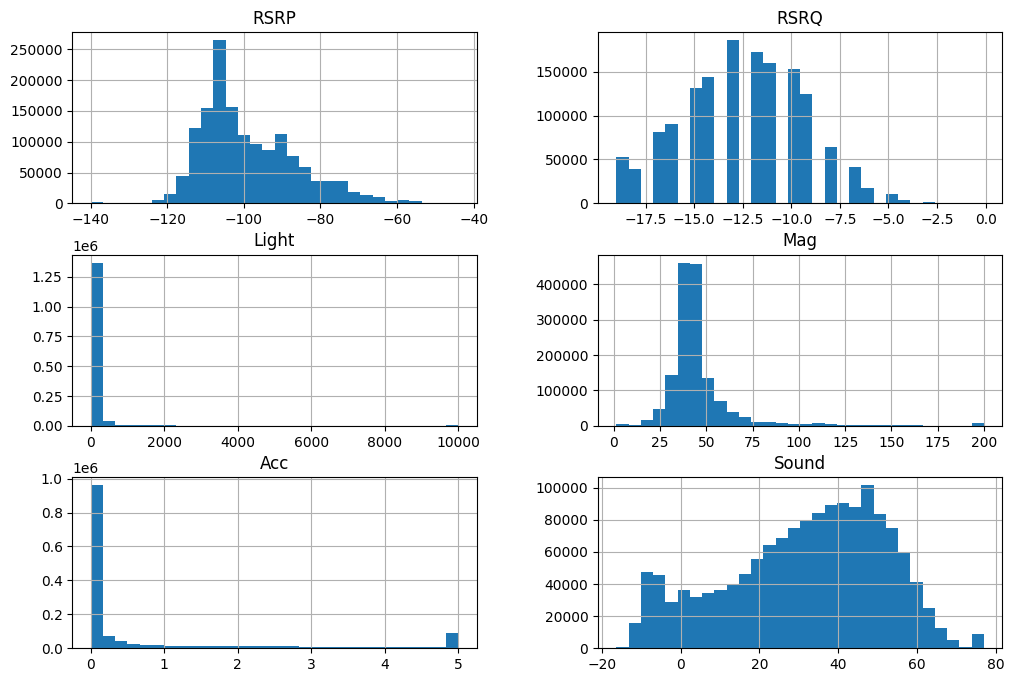

In [13]:
# quick inspection of the distribution of each variable
IOD[num_vars].hist(bins=30, figsize=(12,8))

In [14]:
# Completing PCA to visualize the data and the separation between indoor and outdoor

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,
                                          test_size=0.3,
                                            random_state=0)

In [15]:
# Standard scaler used
standard = StandardScaler()


X_train_pca = standard.fit_transform(X_train)
X_test_pca = standard.transform(X_test)

In [16]:
# decomposition for graphing purposes
pca = PCA(n_components = 2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

print(explained_variance)

[9.98980619e-01 4.54216955e-04]


In [17]:
# Graphing

pcs = pd.DataFrame(data = X_train_pca
             , columns = ['PC1', 'PC2'])
pcs_scat = pcs.merge(y, left_index = True, right_index = True)

pcs_scat.head()

,PC1,PC2,IO
0,-185.611238,30.843527,1.0
1,-185.565149,16.167801,1.0
2,-187.541617,-11.266769,1.0
3,-187.508637,-23.995860,1.0
4,-176.610570,27.173793,1.0


<Axes: xlabel='PC1', ylabel='PC2'>

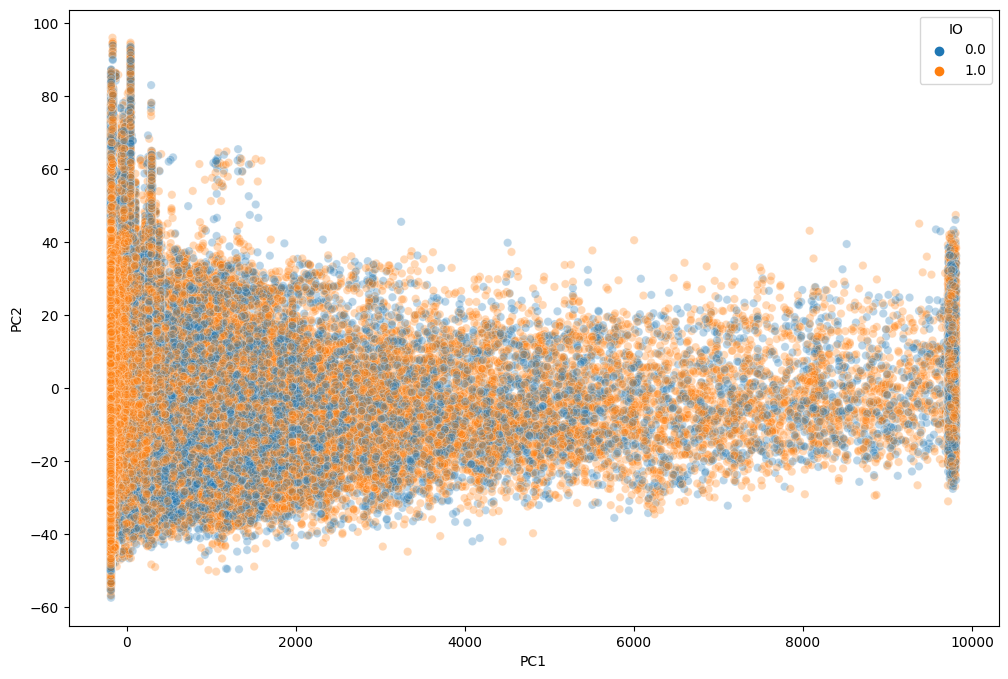

In [18]:
# Plottting
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="PC1", y="PC2",
    data=pcs_scat,
    hue = 'IO',
    legend="full",
    alpha=0.3
)

# Model 1: LSTM
Paper said they used an LSTM model, attempting that here, but can change if needed

In [19]:
# Scaling features for better model performance
sc = MinMaxScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

In [20]:
X_train_scaled

array([[3.64583333e-01, 5.30973451e-01, 2.00000000e-04, ...,
        1.27429940e-01, 1.00000000e+00, 0.00000000e+00],
       [5.41666667e-01, 3.71681416e-01, 2.00000000e-04, ...,
        2.88655589e-01, 0.00000000e+00, 0.00000000e+00],
       [3.22916667e-01, 1.06194690e-01, 0.00000000e+00, ...,
        6.72491065e-01, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.58333333e-01, 4.24778761e-01, 1.10000000e-03, ...,
        4.70934919e-01, 1.00000000e+00, 0.00000000e+00],
       [3.95833333e-01, 5.30973451e-01, 0.00000000e+00, ...,
        7.64058782e-01, 0.00000000e+00, 0.00000000e+00],
       [3.75000000e-01, 5.84070796e-01, 0.00000000e+00, ...,
        9.94539894e-02, 0.00000000e+00, 0.00000000e+00]])

In [21]:
# Reshaping for input layer
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1],1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1],1))

In [22]:
X_train_reshaped

array([[[3.64583333e-01],
        [5.30973451e-01],
        [2.00000000e-04],
        ...,
        [1.27429940e-01],
        [1.00000000e+00],
        [0.00000000e+00]],

       [[5.41666667e-01],
        [3.71681416e-01],
        [2.00000000e-04],
        ...,
        [2.88655589e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.22916667e-01],
        [1.06194690e-01],
        [0.00000000e+00],
        ...,
        [6.72491065e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       ...,

       [[4.58333333e-01],
        [4.24778761e-01],
        [1.10000000e-03],
        ...,
        [4.70934919e-01],
        [1.00000000e+00],
        [0.00000000e+00]],

       [[3.95833333e-01],
        [5.30973451e-01],
        [0.00000000e+00],
        ...,
        [7.64058782e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.75000000e-01],
        [5.84070796e-01],
        [0.00000000e+00],
        ...,
        [9.94539894e-02],
        [0.0000

In [23]:
# Instantiating model
regressor = Sequential()

In [24]:
# Adding layers

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_reshaped.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [25]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 8, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 8, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [26]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [27]:
history = regressor.fit(X_train_reshaped, y_train, epochs = 10, batch_size = 1024)

Epoch 1/10
1008/1008 [==============================] - 85s 81ms/step - loss: 0.1606
Epoch 2/10
1008/1008 [==============================] - 82s 81ms/step - loss: 0.0930
Epoch 3/10
1008/1008 [==============================] - 81s 80ms/step - loss: 0.0802
Epoch 4/10
1008/1008 [==============================] - 81s 80ms/step - loss: 0.0753
Epoch 5/10
1008/1008 [==============================] - 81s 80ms/step - loss: 0.0721
Epoch 6/10
1008/1008 [==============================] - 81s 80ms/step - loss: 0.0694
Epoch 7/10
1008/1008 [==============================] - 81s 80ms/step - loss: 0.0671
Epoch 8/10
1008/1008 [==============================] - 81s 81ms/step - loss: 0.0644
Epoch 9/10
1008/1008 [==============================] - 81s 80ms/step - loss: 0.0622
Epoch 10/10
1008/1008 [==============================] - 81s 80ms/step - loss: 0.0599


Ref1: https://www.pluralsight.com/guides/deep-learning-model-perform-binary-classification

Ref2: https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [28]:
# Make predictions on the test set
y_pred = regressor.predict(X_test_reshaped)

# If your target variable 'IO' is binary, you might want to round the predictions to 0 or 1
y_pred_binary = np.round(y_pred)


13813/13813 [==============================] - 42s 3ms/step


In [29]:
y_pred_binary

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [30]:

# Convert y_test to binary if needed
y_test_binary = np.round(y_test)
# Confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[153949  13862]
 [ 17633 256543]]


In [31]:
print("Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91    167811
         1.0       0.95      0.94      0.94    274176

    accuracy                           0.93    441987
   macro avg       0.92      0.93      0.92    441987
weighted avg       0.93      0.93      0.93    441987



In [32]:
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.9287422480751696


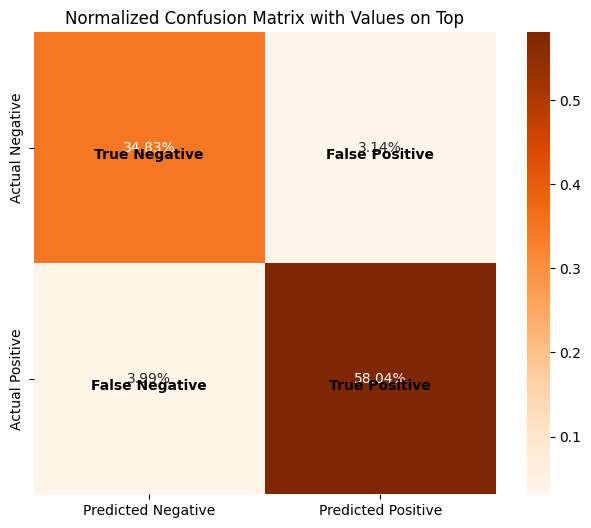

In [33]:
# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Define labels for clarity
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Normalize the confusion matrix based on the total number of rows in the testing set
conf_matrix_normalized = conf_matrix / len(y_test)

# Plotting the confusion matrix heatmap with normalized values
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Oranges', cbar=True, square=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# Add labels to each cell
for i, label in enumerate(labels):
    plt.text(i % 2 + 0.5, i // 2 + 0.5, label, ha='center', va='top', color='black', fontsize=10, fontweight='bold')

plt.title('Normalized Confusion Matrix with Values on Top')
plt.show()

#Model 2: CNN

Model 4: CNN according to the description of the paper:



"the window size w increases, i.e., as we take into account
a larger number of the past sensor readings. Four different
windows sizes are considered: 6, 12, 25, and 50 s. In the implementation
of the proposed model, we skip the max-pooling
layer for w = 6 and 12, whilst for w = 25 and 50, we
use 1 and 2 max-pooling layers, respectively. In this manner,
we can reduce the training computational cost by preserving
sequences with small length in the input of the ALSTM.
Specifically, the input sequence passed to the ALSTM has
a length equal to 12, for w = 25 and 50."


In [34]:


# Choose the desired window size (w)
window_size = 25  # You can change this to 6, 12, 25, or 50

# Reshape the input data to fit a 1D Convolutional layer
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

cnn_classifier = Sequential()

# Add a 1D Convolutional layer with variable kernel size based on the window size
cnn_classifier.add(Conv1D(filters=32, kernel_size=3 if window_size in [25, 50] else 1, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))

# Add max-pooling layers based on the window size
if window_size in [25, 50]:
    cnn_classifier.add(MaxPooling1D(pool_size=2))
if window_size == 50:
    cnn_classifier.add(MaxPooling1D(pool_size=2))

# Flatten the output before passing it to Dense layers
cnn_classifier.add(Flatten())

# Add Dense layers
cnn_classifier.add(Dense(units=50, activation='relu'))
cnn_classifier.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
cnn_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
cnn_classifier.fit(X_train_cnn, y_train, epochs=10, batch_size=1024)

Epoch 1/10
1008/1008 [==============================] - 6s 6ms/step - loss: 0.2977 - accuracy: 0.8705
Epoch 2/10
1008/1008 [==============================] - 6s 6ms/step - loss: 0.2416 - accuracy: 0.9004
Epoch 3/10
1008/1008 [==============================] - 7s 7ms/step - loss: 0.2332 - accuracy: 0.9053
Epoch 4/10
1008/1008 [==============================] - 5s 5ms/step - loss: 0.2276 - accuracy: 0.9084
Epoch 5/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.2232 - accuracy: 0.9104
Epoch 6/10
1008/1008 [==============================] - 3s 3ms/step - loss: 0.2192 - accuracy: 0.9122
Epoch 7/10
1008/1008 [==============================] - 4s 3ms/step - loss: 0.2154 - accuracy: 0.9138
Epoch 8/10
1008/1008 [==============================] - 4s 4ms/step - loss: 0.2122 - accuracy: 0.9148
Epoch 9/10
1008/1008 [==============================] - 3s 3ms/step - loss: 0.2092 - accuracy: 0.9159
Epoch 10/10
1008/1008 [==============================] - 3s 3ms/step - loss: 0.206

In [35]:
# Make predictions on the test set
y_pred = cnn_classifier.predict(X_test_reshaped)

# round the predictions to 0 or 1
y_pred_binary = np.round(y_pred)

13813/13813 [==============================] - 13s 906us/step


In [36]:
y_pred_binary

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [37]:
# Evaluate the performance

# Convert y_test to binary if needed
y_test_binary = np.round(y_test)
# Confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[149651  18160]
 [ 17700 256476]]


In [38]:
print("Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89    167811
         1.0       0.93      0.94      0.93    274176

    accuracy                           0.92    441987
   macro avg       0.91      0.91      0.91    441987
weighted avg       0.92      0.92      0.92    441987



In [39]:
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.9188663919979547
